In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
# import src.vncNet as vncNet
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
import datetime
import os

from pyarrow import feather
# from src.plot_utils import *

In [3]:
def process_eigenvalues(weights, dt=1e-3, tau=20e-3, gains=1, tanh_gain_effect=0.75, synaptic_re_weight=0.03):
    # normalize the weights
    weights = weights * (synaptic_re_weight * tanh_gain_effect) * gains

    # prepare the weights for the discrete dynamical system simulation
    weights = (1 - dt / tau) * np.eye(len(weights)) + dt * weights / tau

    # get the eigenvalues of the weights
    eigenvalues, _ = np.linalg.eig(weights)
    return eigenvalues


def display_eigenvals_and_frequencies(eigenvalues, dt=1e-3, **kwargs):
    # plot the eigenvalues
    fig, axes = plt.subplots(1, 2, figsize=(10, 5) if "figsize" not in kwargs else kwargs["figsize"])
    kwargs.pop("figsize", None)
    yscale = kwargs.pop("yscale", None)
    title = kwargs.pop("title", None)
    axes[0].set_title(title + f"\nN={len(eigenvalues)}", fontsize=15)

    min_lim = np.floor(np.minimum(eigenvalues.real.min(), eigenvalues.imag.min()))
    max_lim = np.ceil(np.maximum(eigenvalues.real.max(), eigenvalues.imag.max()))
    if "s" not in kwargs:
        kwargs["s"] = 20
    if "marker" not in kwargs:
        kwargs["marker"] = "x"
    if "color" not in kwargs:
        kwargs["color"] = "k"
    axes[0].scatter(eigenvalues.real, eigenvalues.imag, **kwargs)
    axes[0].add_patch(Circle((0, 0), 1, color="k", lw=0.5, fill=False))
    axes[0].set_xlabel("Real")
    axes[0].set_ylabel("Imaginary")
    axes[0].set_aspect("equal")
    axes[0].set_xticks(np.arange(min_lim, max_lim + 1, 1))
    axes[0].set_yticks(np.arange(min_lim, max_lim + 1, 1))
    sns.despine(offset=0, trim=True, ax=axes[0])

    eigenvalues = eigenvalues[eigenvalues.imag > 0]
    frequencies = np.arctan2(eigenvalues.imag, eigenvalues.real) / dt / (2 * np.pi)
    axes[1].hist(
        frequencies,
        bins=np.arange(0, np.ceil(frequencies.max()), 1),
        color="k" if "color" not in kwargs else kwargs["color"],
    )
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel("Count")
    if yscale is not None:
        axes[1].set_yscale(yscale)
    sns.despine(offset=0, trim=True, ax=axes[1])

## All of MANC

In [ ]:
wTable = feather.read_feather("../../data/MANC weights/20231003_allMANC/neuron-properties.feather")
W = feather.read_feather("../../data/MANC weights/20231003_allMANC/W_20231027_unsorted.feather")

print("W shape: ", W.shape)
gains = 1
eigenvalues = process_eigenvalues(W, gains=gains)

In [ ]:
display_eigenvals_and_frequencies(eigenvalues, dt=1e-3, s=1, alpha=0.2, figsize=(15, 4), yscale="log", title="all MANC weights")

## DN to MNs of MANC

In [12]:
Wpd = pd.read_csv("../../../data/manc t1 connectome data/W_20231020_DNtoMN_unsorted.csv")
W = (
    Wpd.drop(columns="bodyId_pre").to_numpy().astype(float)
)  # changing the type to float is what allows it to work, TODO catch this and fix
wTable = pd.read_csv(
    "../../../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv", index_col=0
)

# Wpd = pd.read_csv("../../data/MANC weights/20250204_T1networkV2/W_20250204_T1networkV2.csv")
# W = (
#     Wpd.drop(columns="bodyId_pre").to_numpy().astype(float)
# )  # changing the type to float is what allows it to work, TODO catch this and fix
# wTable = pd.read_csv(
#     "../../data/MANC weights/20250204_T1networkV2/wTable_20250204_T1networkV2_withModules.csv", index_col=0
# )
print("W shape: ", W.shape)
gains = 1
eigenvalues = process_eigenvalues(W, gains=gains, dt=1e-3)

W shape:  (4561, 4561)


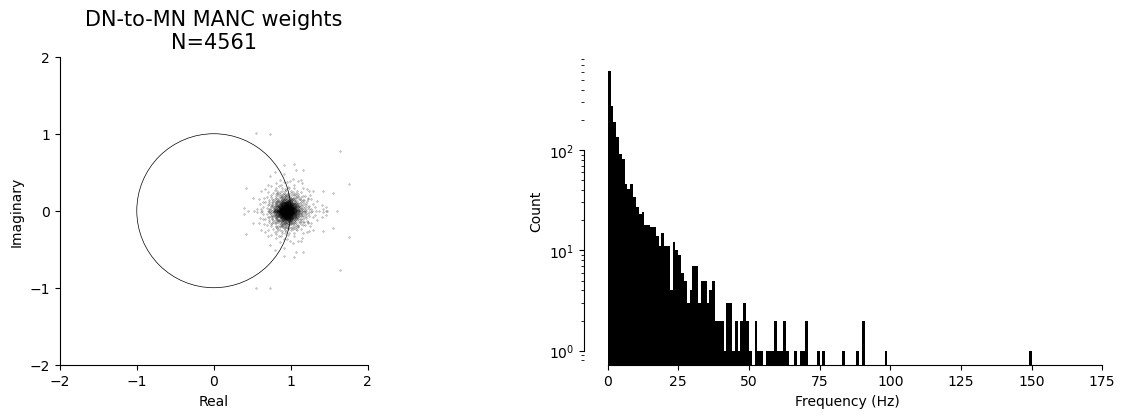

In [16]:
display_eigenvals_and_frequencies(eigenvalues, dt=1e-3, s=1, alpha=0.2, figsize=(15, 4), yscale="log", title="DN-to-MN MANC weights")
plt.savefig("eigenvals_full_circuit_plots.svg")

In [15]:
np.save("eigenvalues_full_circuit.npy", eigenvalues)